In [11]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

import matplotlib.pyplot as plt
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pickle

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Record Audio

In [13]:
def feature_extractor(sound_path, win_length_ms=25, hop_length_ms=10):
    # Load the audio file
    signal, sr = librosa.load(sound_path,sr=8000)
    # signal,sr = wavfile.read(sound_path)
    # Extract MFCCs
    win_length_samples = int(sr * win_length_ms / 1000)
    hop_length_samples = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length_samples, win_length=win_length_samples)
    # mfccs = mfcc(signal,samplerate=sr,nfft = 2048,numcep=13,nfilt=13)
    
    #Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [14]:
def preprocess(path, is_pca=0, num_pca = 2, window_length_ms=20, hop_length_ms=10):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=8000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    # samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file,window_length_ms,hop_length_ms)
    # tot= np.concatenate((a,b,c,d)).T
    tot = d.T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [15]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50,window_length_ms=20, hop_length_ms=10):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            # samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            # samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            # tot = np.concatenate((a, b, c, d)).T
            tot = d.T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

# Histogram plot to show that its mixture of gaussians

# Main Code

In [16]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

In [17]:
train_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Train","../Dataset/Language-Recognition-VADaudio/Tamil-Train","../Dataset/Language-Recognition-VADaudio/Telugu-Train"]
test_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Test","../Dataset/Language-Recognition-VADaudio/Tamil-Test","../Dataset/Language-Recognition-VADaudio/Telugu-Test"]

In [18]:
import math
from scipy.stats import multivariate_normal
import numpy as np


In [19]:
class GMMNew:
    def __init__(
        self, 
        n_mixtures=120, 
        max_iter=100, 
        covar_type='full', 
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.log_likelihood_plot_list = None
        

    def p(self, data, mean, cov):
        dist = multivariate_normal(mean=mean, cov=cov,allow_singular=True)
        return dist.pdf(data)
    
    
    def get_score(self,data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        return np.mean(np.log(resp.sum(axis=1)))
    
    # Function to get the log likelihood
    def get_loglikelihood(self,data):
        return self.get_score(data)
    
    def aic_bic(self, data):
        # Get the log-likelihood
        log_likelihood = self.get_loglikelihood(data)
        
        # Calculate the number of parameters in the model
        n_params = self.n_mixtures
        
        # Calculate AIC and BIC
        aic = -2 * log_likelihood*data.shape[0] + 2 * n_params
        bic = -2 * log_likelihood*data.shape[0] + n_params * np.log(len(data))
        
        return aic, bic
    
    def full_covar(self, data, resp):
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = data - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i].flat[::data.shape[1] + 1] += 1e-6
        return new_covs
            
    def diag_covar(self, data, resp):
        n_features = data.shape[1]
        new_covs = np.zeros((self.n_mixtures, n_features, n_features))
        wik = resp[:,i]
        for i in range(self.n_mixtures):
            num = wik.reshape(data.shape[0],1)*np.square(data-self.means[i])
            column_sums = np.sum(num,axis=0) # result will be (1,d) matrix
            assert(column_sums.shape==(1,data.shape[1]))
            column_sums /= np.sum(wik)
            new_covs[i] = np.diag(column_sums+1e-6) # regularisation term
        return new_covs
    
    def e_step(self, data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        # normalize the sum
        resp = resp / resp.sum(axis=1)[:, None]
        return resp
    
    def m_step(self, data, resp):        
        # re-estimation for alphas
        new_alphas = resp.mean(axis=0)
        
        # re-estimation for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i][:, None], data).sum(axis=0) / resp[:, i].sum()
        
        # re-estimation for covariance matrix
        if self.covar_type == 'full':
            new_covs = self.full_covar(data, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(data, resp)
            
        return new_alphas, new_means, new_covs
    
        
    def fit(self, data):
        n_features = data.shape[1]
        last = 0
        # intialize empty lists to store images and 
        self.log_likelihood_plot_list = []
        
        # initialize means
        kmeans_model =  KMeans(self.n_mixtures).fit(data)
        self.means = kmeans_model.cluster_centers_
        
        # initialize cov
        self.covs = np.zeros((self.n_mixtures, n_features, n_features))
        data_labels = kmeans_model.labels_
    
        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(data[data_labels == i].T+0.1)
        
        # EM - algorithm
        for step in range(self.max_iter):
            last = step
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(data)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(data, resp)
            
            
            # Check for convergence criteria
            if np.allclose(self.alphas, alphas, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.means, means, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.covs, covs, rtol=1e-4, atol=1e-4):
                print("Converged at",step)
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]

        # plt.plot(range(last), self.log_likelihood_plot_list,color='g', linewidth=2)
        # plt.xlabel('Number of Iteration')
        # plt.ylabel('Log Likelihood')
        # plt.title('Variation of Log Likelihood for each iteration')
        # plt.tight_layout()  
        # plt.show()
        

In [20]:
from sklearn.metrics import f1_score
from sklearn.metrics import silhouette_score

def pipeline(n_components_gmm,is_pca,num_pca):
    gmms = []
    i = 0
    for path in train_paths:
        i += 1
        X = preprocess_folder(path,is_pca,num_pca,items=10)
        gmm = GMMNew(n_components_gmm,100,'full')
        gmm.fit(data=X)
        with open(f'gmm_{n_components_gmm}_{num_pca}_{i}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        gmms.append(gmm)
        
        print(f"{path} is done")
        aic, bic = gmm.aic_bic(X)
        print(f"Model {i} AIC: {aic}, BIC: {bic}")
        

    # Initialize confusion matrix
    confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

    for idx, path in enumerate(test_paths):
        # Initialize counters for each class
        class_counts = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file,is_pca,num_pca)
                log_likelihood = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm    = gmms[i]  #checking with each model one by one
                    log_likelihood[i] = gmm.get_score(vector)
            
                winner = np.argmax(log_likelihood)
                class_counts[winner] += 1  # Increment the count for the winner class

        # Update confusion matrix
        for true_label, count in class_counts.items():
            confusion_matrix[idx, true_label] = count

    # Iterate through each data point in X and assign cluster labels
    cluster_labels_list = []
    for x in X:
        log_likelihood = [gmm.get_score(x) for gmm in gmms]  # Calculate log-likelihood for each GMM
        predicted_cluster = np.argmax(log_likelihood)  # Assign to cluster with maximum log-likelihood
        cluster_labels_list.append(predicted_cluster)

    # Convert cluster labels to numpy array
    cluster_labels = np.array(cluster_labels_list)

    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Print the silhouette score
    print("Silhouette Score:", silhouette_avg)

    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")

## Plotting Graphs - Confusion Matrix

Num comp:1, Num PCA:1
Converged at 1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 70386.30931128941, BIC: 70392.91543069003


Converged at 1
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 77176.06834427244, BIC: 77182.7540981054
Converged at 1
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 53832.664585441176, BIC: 53839.03118827396
Silhouette Score: 0.2492241


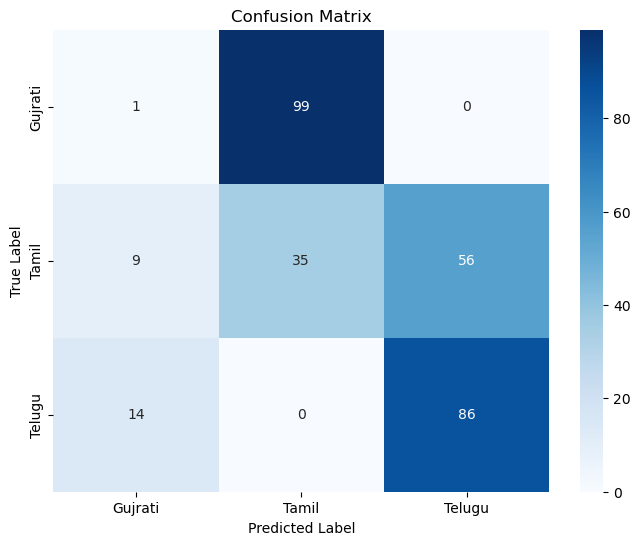

Overall Accuracy: 40.67%
Num comp:2, Num PCA:1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 69528.19420758521, BIC: 69541.40644638643
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 75908.61870399583, BIC: 75921.99021166174
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52974.734519398415, BIC: 52987.46772506398
Silhouette Score: 0.40348628


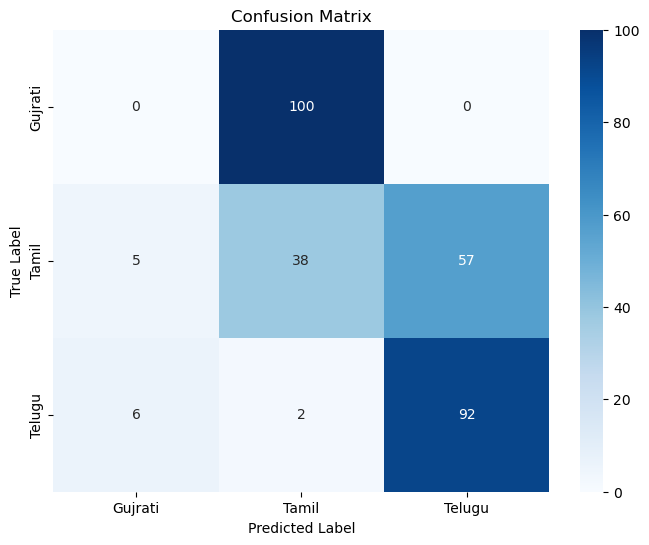

Overall Accuracy: 43.33%
Num comp:4, Num PCA:1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 68947.10909097419, BIC: 68973.53356857663
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 75277.55954941797, BIC: 75304.30256474981
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52523.48731311638, BIC: 52548.953724447514
Silhouette Score: 0.12981325


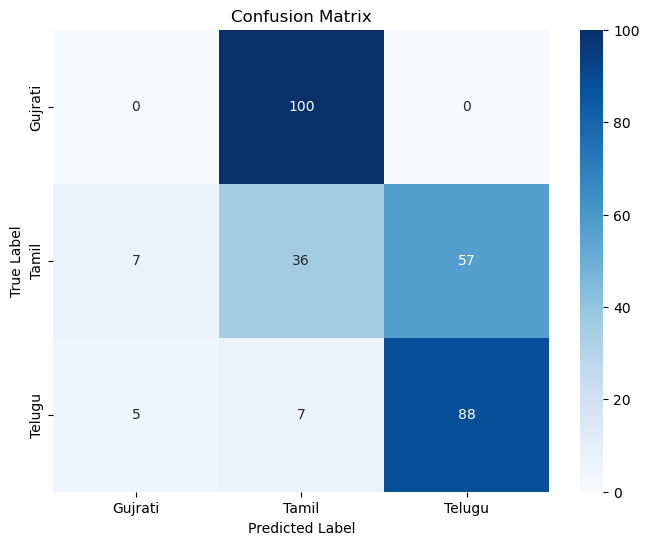

Overall Accuracy: 41.33%
Num comp:8, Num PCA:1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 68868.49425224774, BIC: 68921.34320745262
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 75225.42438649994, BIC: 75278.91041716363
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52481.9855547657, BIC: 52532.918377427966
Silhouette Score: 0.11596737


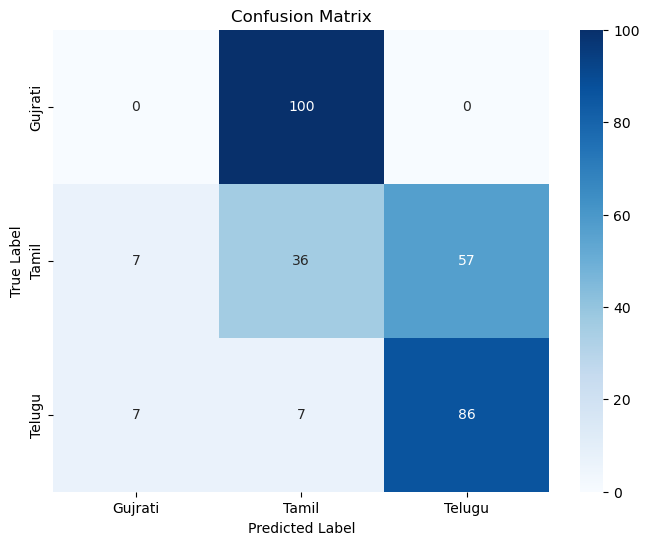

Overall Accuracy: 40.67%
Num comp:16, Num PCA:1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 68819.92708800371, BIC: 68925.62499841348
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 75191.25312485445, BIC: 75298.22518618182
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52450.7465833865, BIC: 52552.61222871104
Silhouette Score: 0.11398926


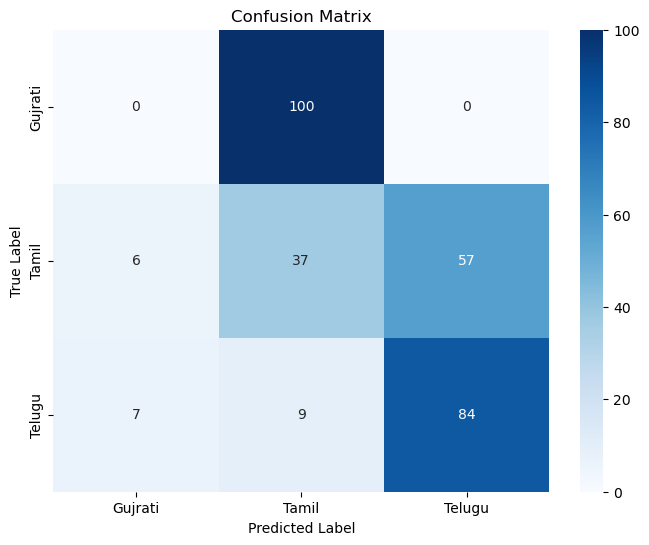

Overall Accuracy: 40.33%
Num comp:32, Num PCA:1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 68813.4536464091, BIC: 69024.84946722865
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 75149.77963338343, BIC: 75363.72375603815
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52438.30698019561, BIC: 52642.038270844685
Silhouette Score: 0.056191437


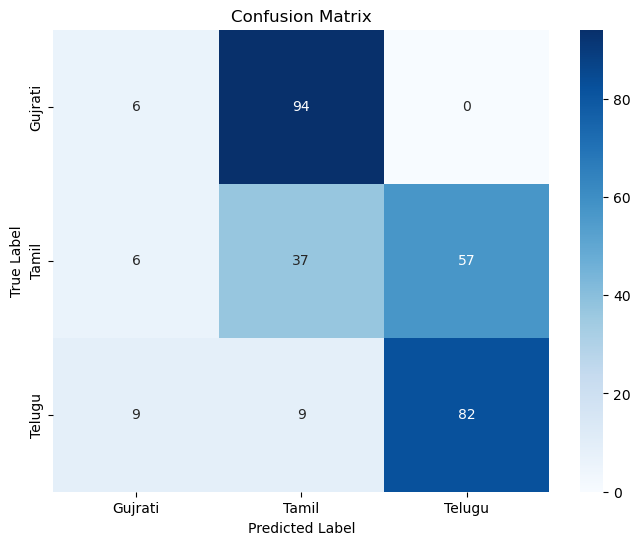

Overall Accuracy: 41.67%
Num comp:64, Num PCA:1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 68773.8786185158, BIC: 69196.67026015487
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 75093.22875108423, BIC: 75521.11699639368
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 52412.62964204196, BIC: 52820.09222334012
Silhouette Score: 0.060085174


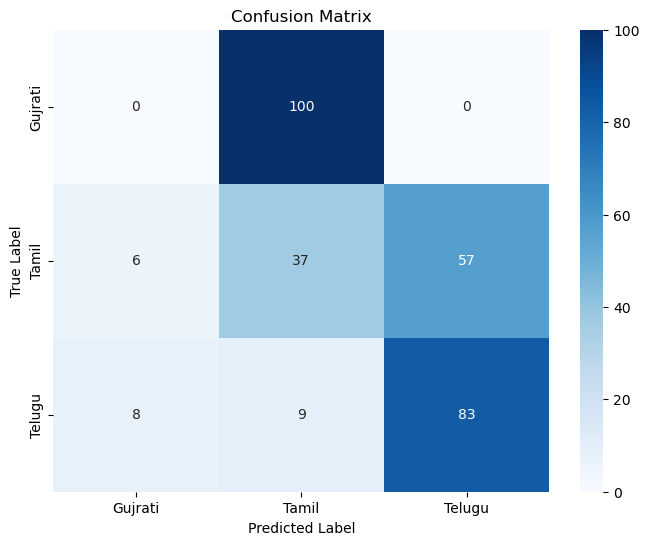

Overall Accuracy: 40.00%
Num comp:1, Num PCA:2
Converged at 1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 128432.4302476533, BIC: 128439.03636705392
Converged at 1
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 138444.87529450213, BIC: 138451.56104833508
Converged at 1
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 97007.83351617515, BIC: 97014.20011900793
Silhouette Score: 0.115046166


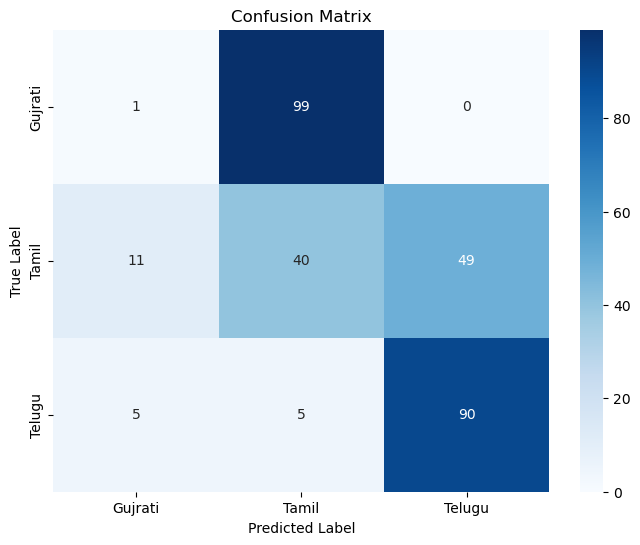

Overall Accuracy: 43.67%
Num comp:2, Num PCA:2
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 127138.77955870051, BIC: 127151.99179750173
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 136994.2384620306, BIC: 137007.60996969652
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 96099.23064972783, BIC: 96111.9638553934
Silhouette Score: 0.08604142


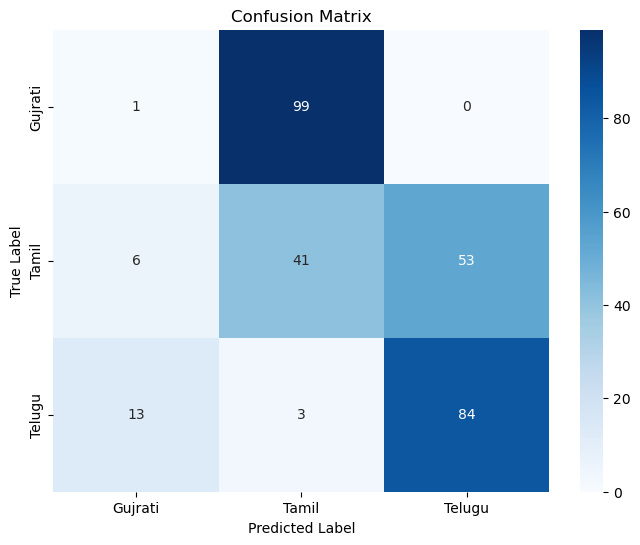

Overall Accuracy: 42.00%
Num comp:4, Num PCA:2
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 126036.03576465498, BIC: 126062.46024225742
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 136218.11685118405, BIC: 136244.85986651588
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 95561.0136593078, BIC: 95586.48007063894
Silhouette Score: 0.0320592


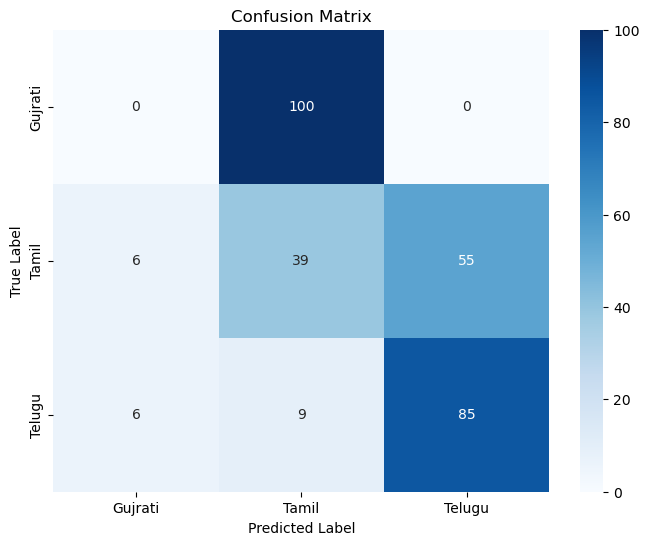

Overall Accuracy: 41.33%
Num comp:8, Num PCA:2
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 125738.52750903853, BIC: 125791.37646424341
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 135480.31879264972, BIC: 135533.8048233134
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 95168.57884771819, BIC: 95219.51167038047
Silhouette Score: -0.011005743


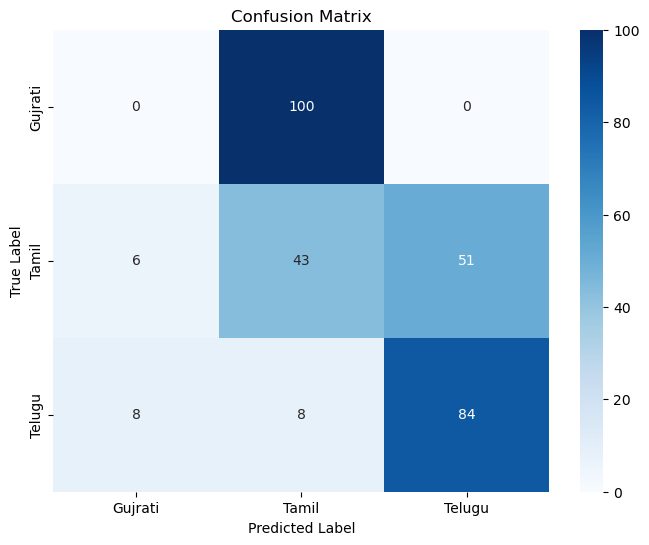

Overall Accuracy: 42.33%
Num comp:16, Num PCA:2
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 125546.67485203674, BIC: 125652.37276244651
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 134771.17880071135, BIC: 134878.15086203872
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 94949.79982685167, BIC: 95051.6654721762
Silhouette Score: -0.0146872075


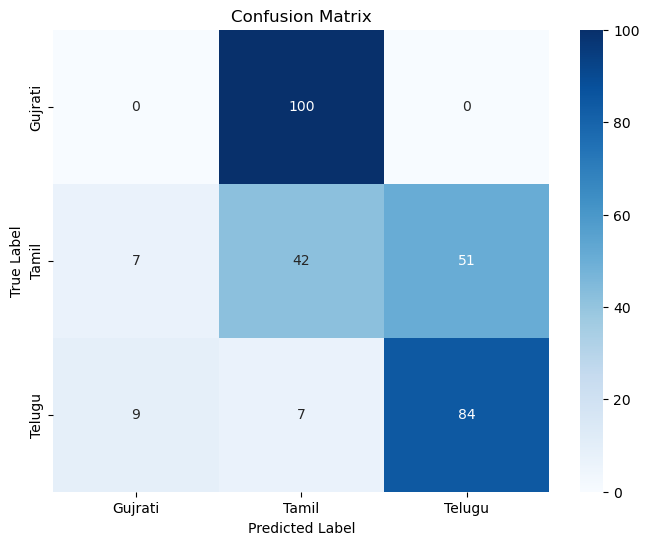

Overall Accuracy: 42.00%
Num comp:32, Num PCA:2
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 125263.81198699167, BIC: 125475.20780781121
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 134404.95389183713, BIC: 134618.89801449186
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 94822.0720067429, BIC: 95025.80329739199
Silhouette Score: -0.0179152


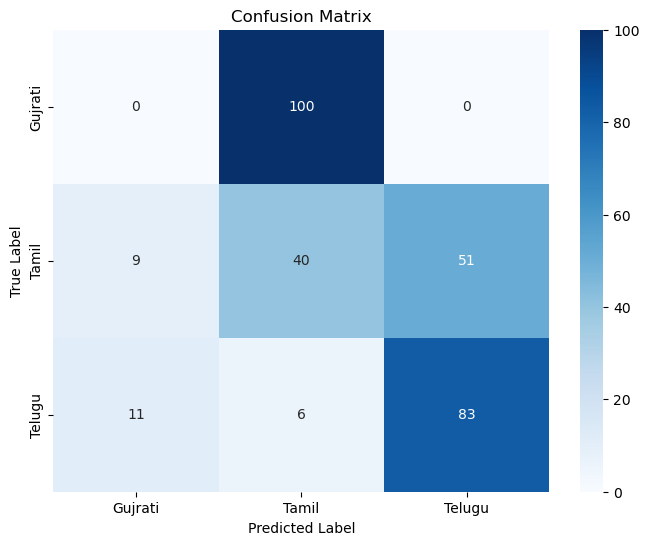

Overall Accuracy: 41.00%
Num comp:64, Num PCA:2
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 124982.93563230717, BIC: 125405.72727394625
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 133924.4831139231, BIC: 134352.37135923255
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 94525.41855028848, BIC: 94932.88113158663
Silhouette Score: -0.043122653


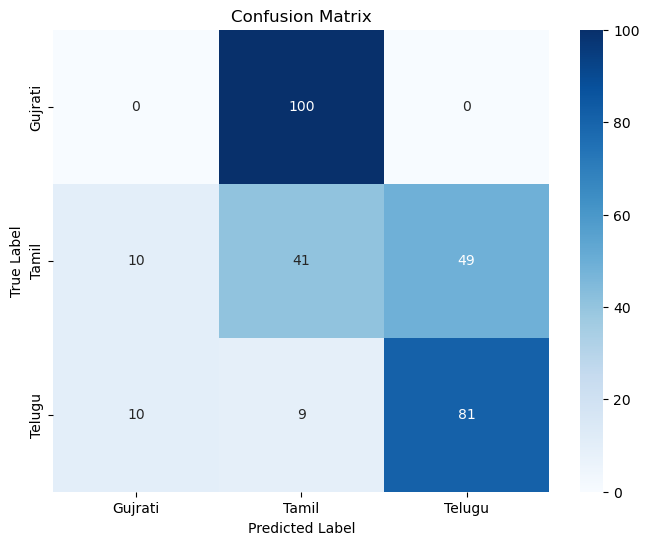

Overall Accuracy: 40.67%
Num comp:1, Num PCA:8
Converged at 1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 420833.27422748564, BIC: 420839.88034688623
Converged at 1
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 454378.7134253487, BIC: 454385.39917918167
Converged at 1
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 316707.4277674665, BIC: 316713.7943702993
Silhouette Score: -0.05005973


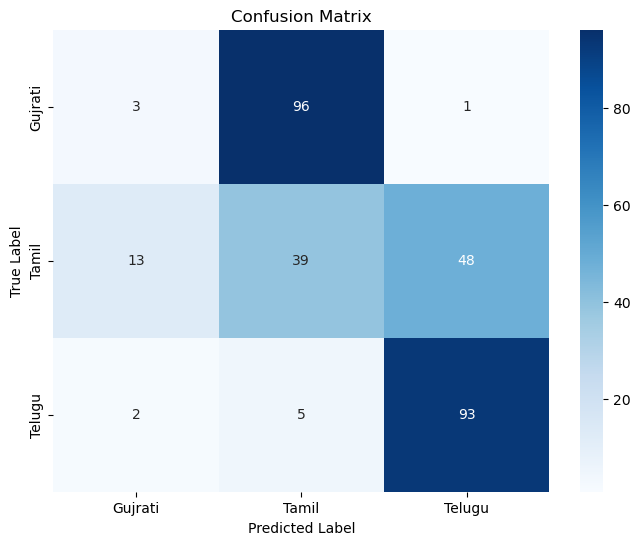

Overall Accuracy: 45.00%
Num comp:2, Num PCA:8
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 417748.80359489087, BIC: 417762.0158336921
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 451408.0989521032, BIC: 451421.4704597691
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 314727.65106961376, BIC: 314740.3842752793
Silhouette Score: -0.08652065


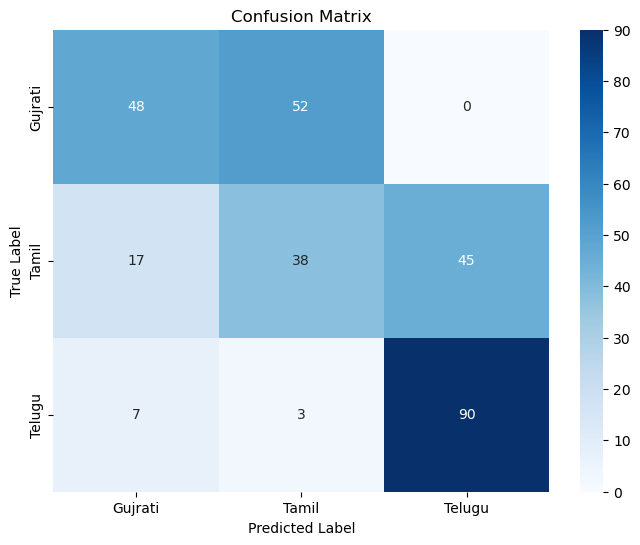

Overall Accuracy: 58.67%
Num comp:4, Num PCA:8
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 414833.63890735735, BIC: 414860.0633849598
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 448769.8185889273, BIC: 448796.5616042591
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 313147.5523525281, BIC: 313173.01876385923
Silhouette Score: -0.03915137


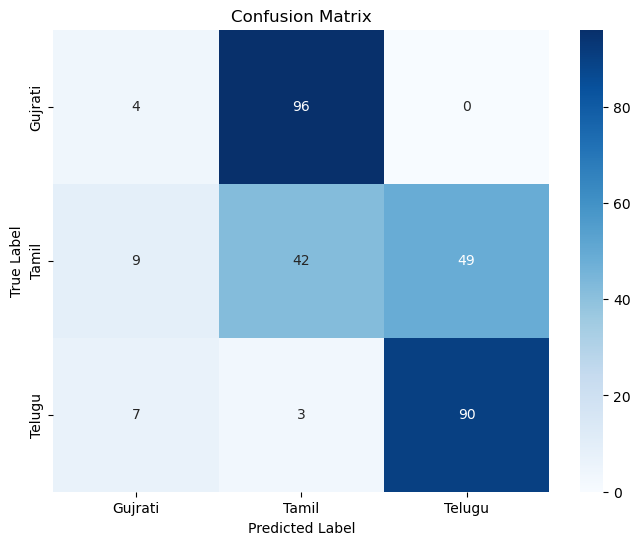

Overall Accuracy: 45.33%
Num comp:8, Num PCA:8
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 411976.3420054939, BIC: 412029.19096069876
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 446203.1324155894, BIC: 446256.61844625307
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 311351.64825097495, BIC: 311402.58107363724
Silhouette Score: -0.060584962


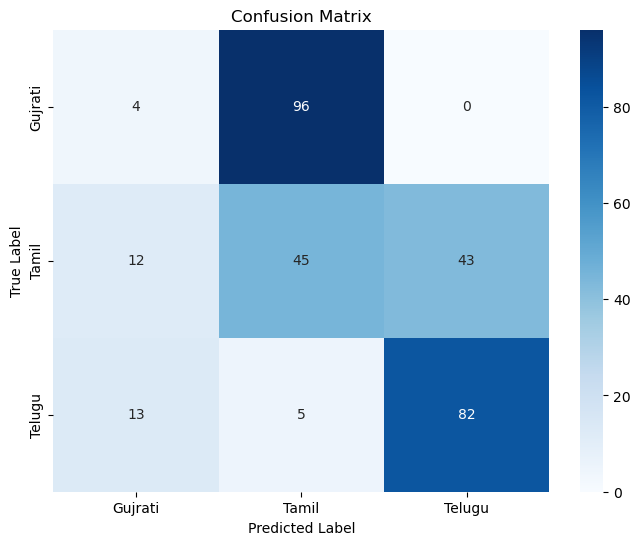

Overall Accuracy: 43.67%
Num comp:16, Num PCA:8
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 409045.8998923425, BIC: 409151.5978027523
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 441852.58311813144, BIC: 441959.5551794588
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 308976.4092816998, BIC: 309078.2749270243
Silhouette Score: -0.051891156


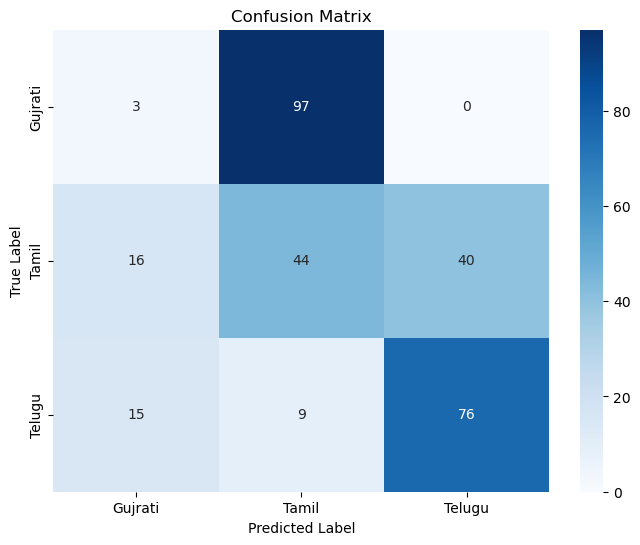

Overall Accuracy: 41.00%
Num comp:32, Num PCA:8
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 404796.3811125967, BIC: 405007.77693341626
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 436783.0563935305, BIC: 436997.00051618525
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 305611.782010874, BIC: 305815.5133015231
Silhouette Score: -0.036448527


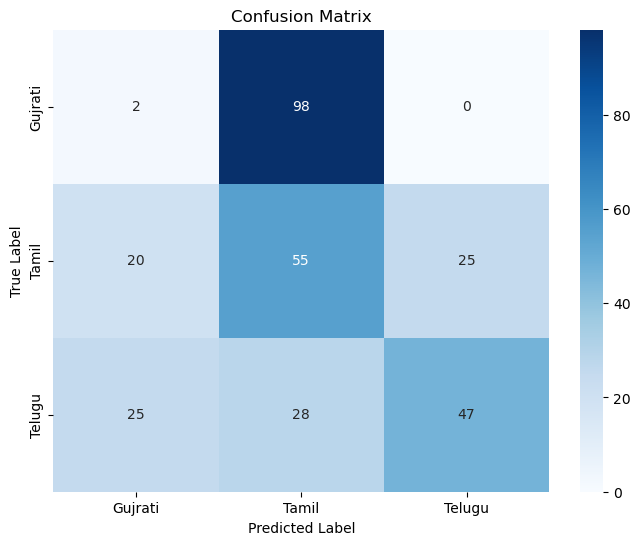

Overall Accuracy: 34.67%
Num comp:64, Num PCA:8
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 398507.1289349672, BIC: 398929.9205766063
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 429591.9330264499, BIC: 430019.82127175934
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 301047.3114370112, BIC: 301454.7740183093
Silhouette Score: -0.08146217


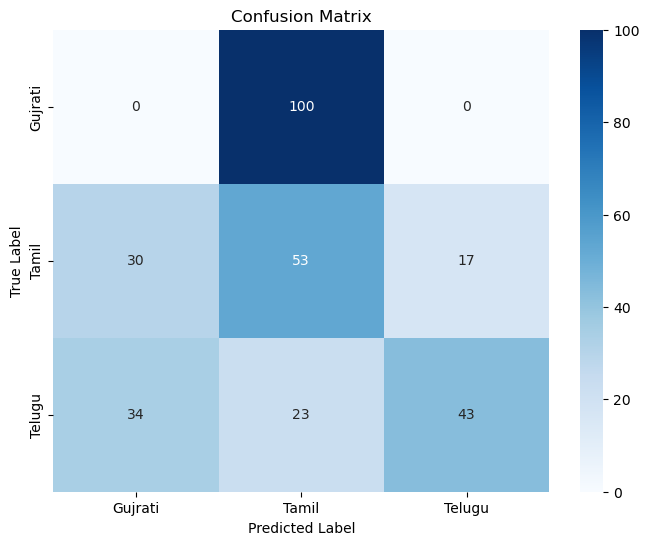

Overall Accuracy: 32.00%
Num comp:1, Num PCA:16
Converged at 1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 736887.0176820117, BIC: 736893.6238014123
Converged at 1
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 795253.8235756111, BIC: 795260.509329444
Converged at 1
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 555846.8314088702, BIC: 555853.198011703
Silhouette Score: -0.027328959


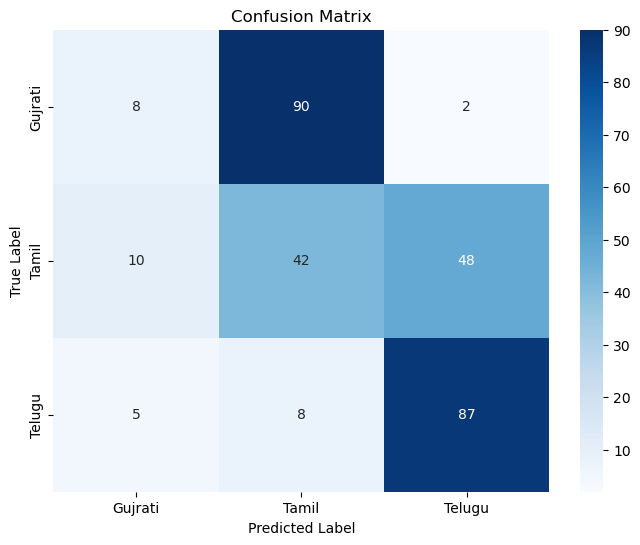

Overall Accuracy: 45.67%
Num comp:2, Num PCA:16
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 732890.5568706859, BIC: 732903.7691094871
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 791332.9444645912, BIC: 791346.3159722572
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 553851.8994373586, BIC: 553864.6326430242
Silhouette Score: 0.0010649877


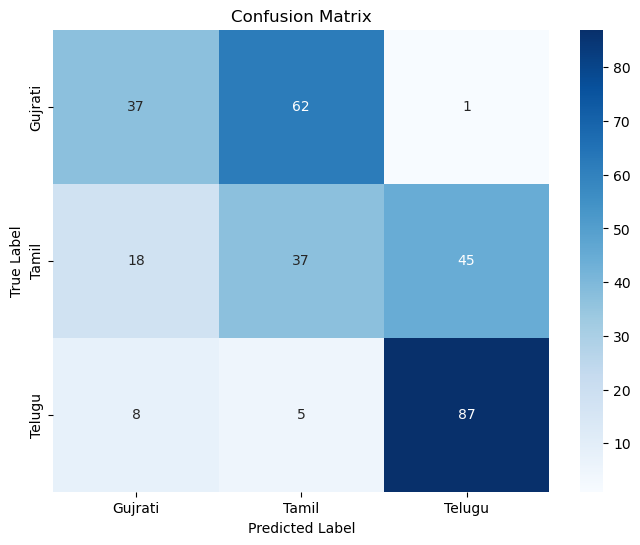

Overall Accuracy: 53.67%
Num comp:4, Num PCA:16
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 728524.3956378929, BIC: 728550.8201154954
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 786007.1404323248, BIC: 786033.8834476566
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 550669.4529120018, BIC: 550694.9193233328
Silhouette Score: -0.04710151


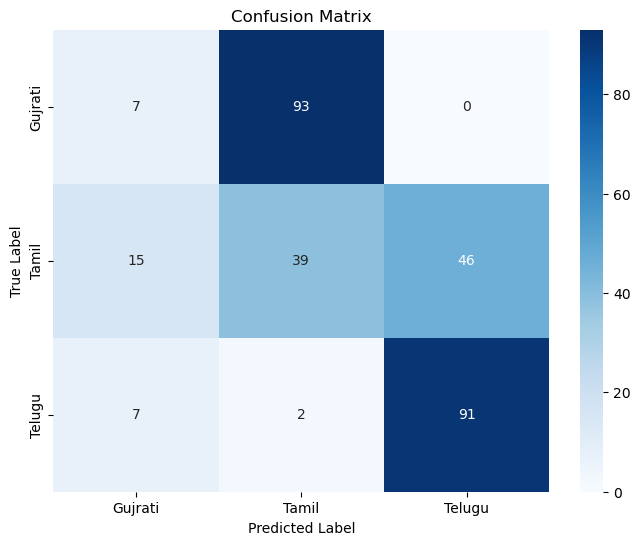

Overall Accuracy: 45.67%
Num comp:8, Num PCA:16
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 723800.2226197799, BIC: 723853.0715749848
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 781193.7211262467, BIC: 781247.2071569104
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 547444.0933986364, BIC: 547495.0262212987
Silhouette Score: -0.043910522


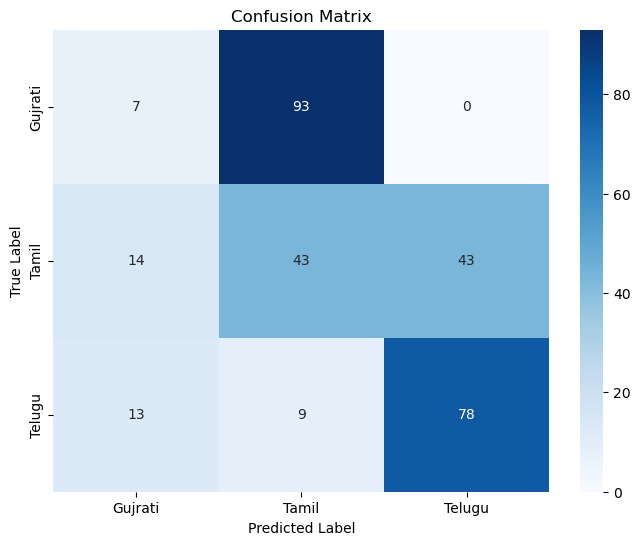

Overall Accuracy: 42.67%
Num comp:16, Num PCA:16
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 717115.6917704532, BIC: 717221.389680863
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 773142.4986071454, BIC: 773249.4706684727
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 542079.678386891, BIC: 542181.5440322156
Silhouette Score: -0.059367765


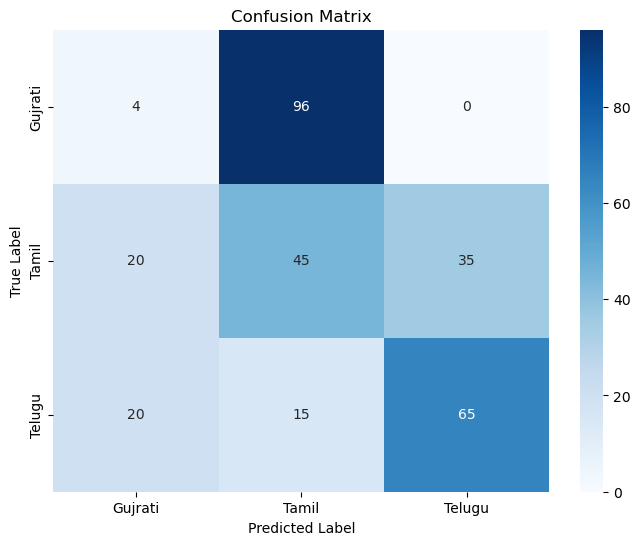

Overall Accuracy: 38.00%
Num comp:32, Num PCA:16
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 707210.9561705095, BIC: 707422.351991329
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 759601.4381516359, BIC: 759815.3822742907
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 534654.4979237638, BIC: 534858.2292144129
Silhouette Score: -0.081836715


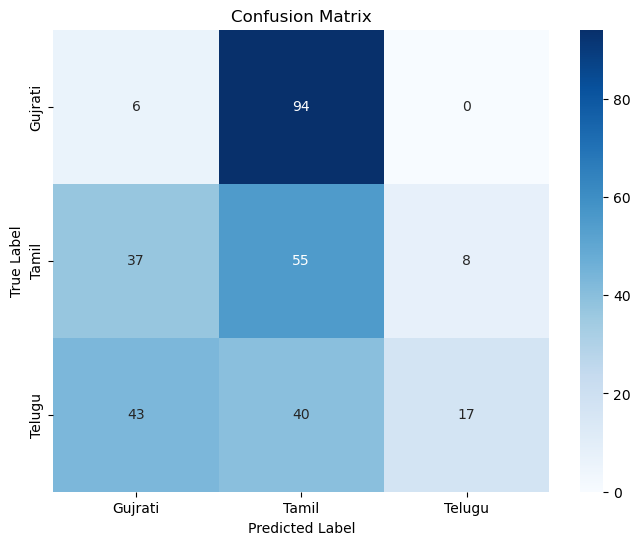

Overall Accuracy: 26.00%
Num comp:64, Num PCA:16
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 692297.9998428926, BIC: 692720.7914845317
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 741089.6226975927, BIC: 741517.5109429022
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 522992.3410713154, BIC: 523399.80365261354
Silhouette Score: -0.08795833


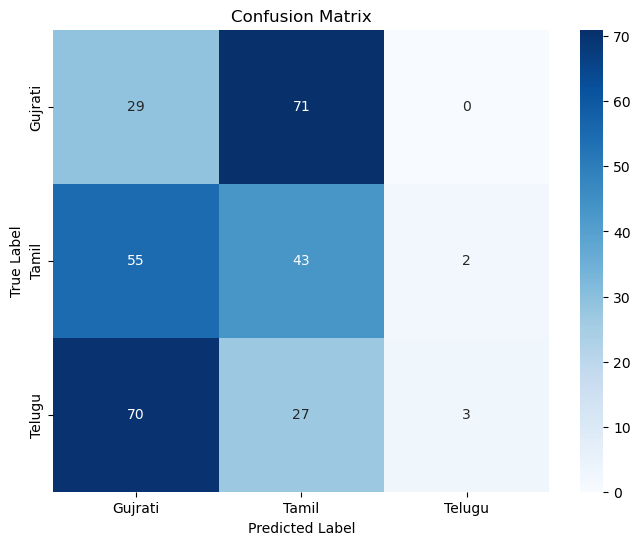

Overall Accuracy: 25.00%
Num comp:1, Num PCA:24
Converged at 1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 953818.0966679882, BIC: 953824.7027873888
Converged at 1
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1027427.3613853778, BIC: 1027434.0471392107
Converged at 1
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 713483.0407332242, BIC: 713489.407336057
Silhouette Score: -0.036424484


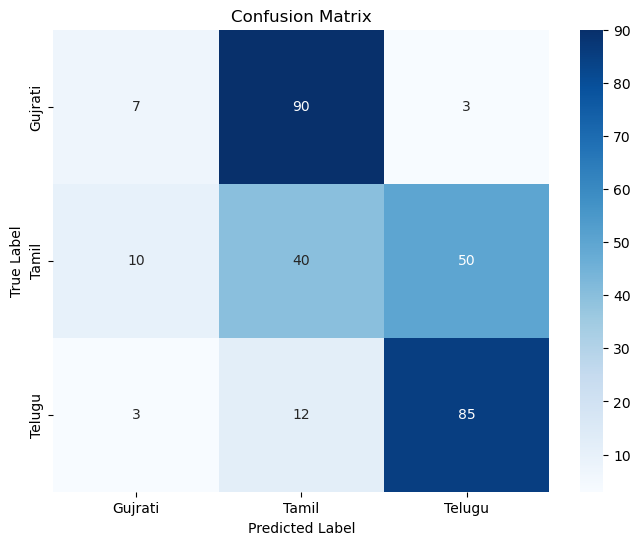

Overall Accuracy: 44.00%
Num comp:2, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 948722.2414484444, BIC: 948735.4536872456
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1021394.7735057923, BIC: 1021408.1450134582
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 709513.7533807372, BIC: 709526.4865864028
Silhouette Score: -0.07016231


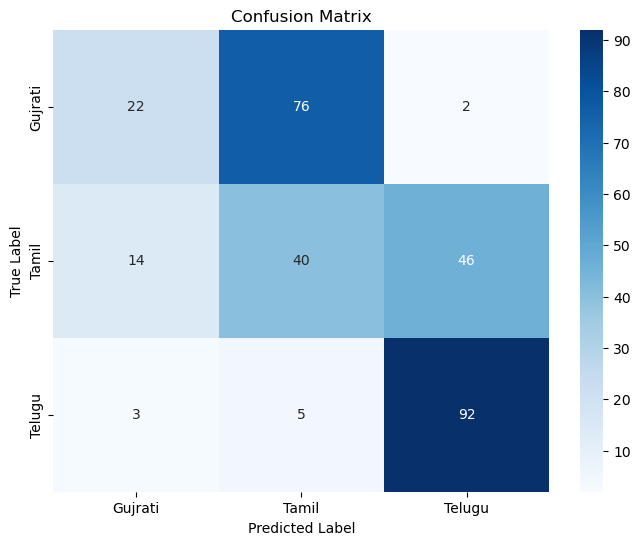

Overall Accuracy: 51.33%
Num comp:4, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 941700.6900479756, BIC: 941727.1145255781
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1014083.0853066106, BIC: 1014109.8283219424
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 705215.8031770141, BIC: 705241.2695883452
Silhouette Score: -0.038022406


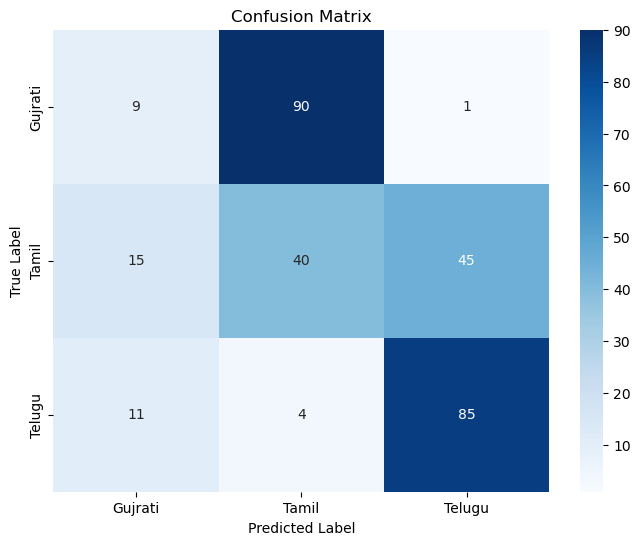

Overall Accuracy: 44.67%
Num comp:8, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 934112.7317876256, BIC: 934165.5807428305
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1006300.5610025465, BIC: 1006354.0470332102
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 699996.2833582147, BIC: 700047.216180877
Silhouette Score: -0.03259573


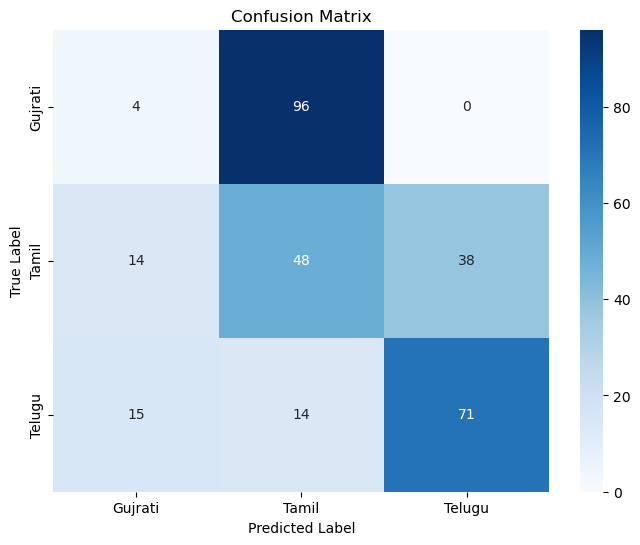

Overall Accuracy: 41.00%
Num comp:16, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 923339.9894154512, BIC: 923445.687325861
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 994214.9390590221, BIC: 994321.9111203494
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 691064.1305402241, BIC: 691165.9961855487
Silhouette Score: -0.056868672


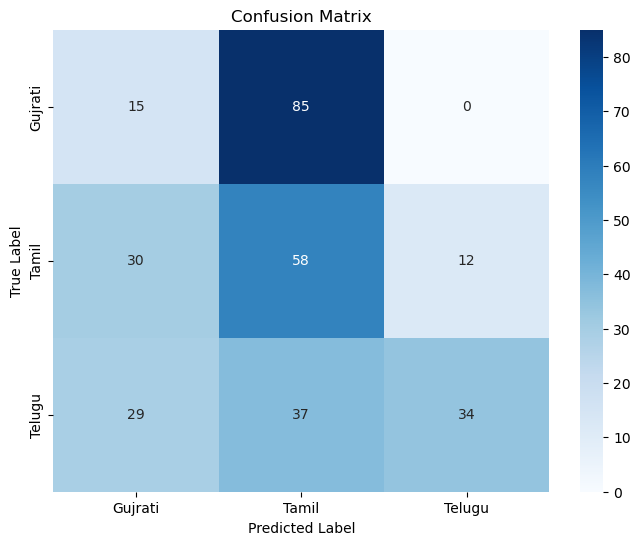

Overall Accuracy: 35.67%
Num comp:32, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 907367.8920036982, BIC: 907579.2878245177
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 976174.1709747167, BIC: 976388.1150973714
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 677766.2287230918, BIC: 677969.9600137408
Silhouette Score: -0.062019013


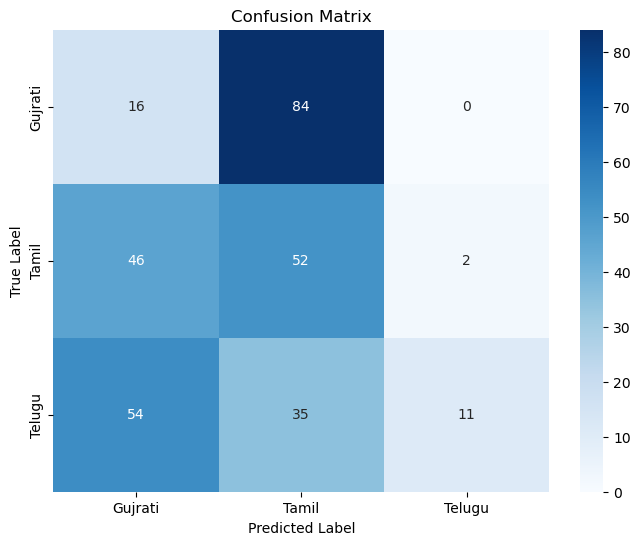

Overall Accuracy: 26.33%
Num comp:64, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 881107.2372437117, BIC: 881530.0288853508
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 946026.6702714353, BIC: 946454.5585167448
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 656745.1082892648, BIC: 657152.570870563
Silhouette Score: -0.11637267


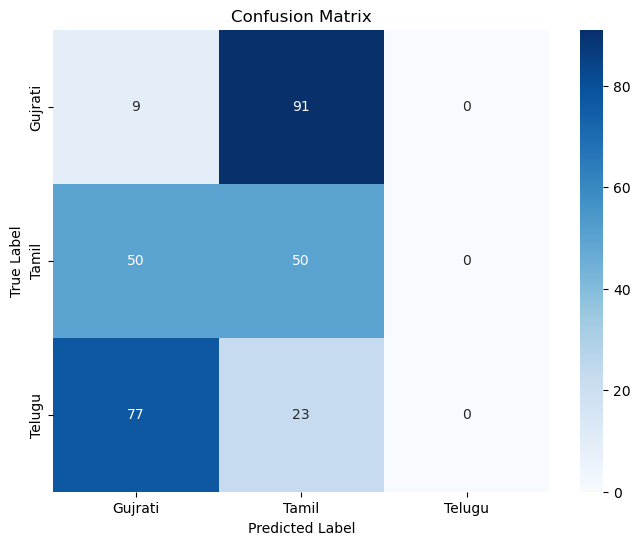

Overall Accuracy: 19.67%
Num comp:1, Num PCA:39
Converged at 1
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1235132.7625081642, BIC: 1235139.3686275647
Converged at 1
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1328750.8959785402, BIC: 1328757.5817323732
Converged at 1
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 920467.9215890539, BIC: 920474.2881918867
Silhouette Score: -0.080226265


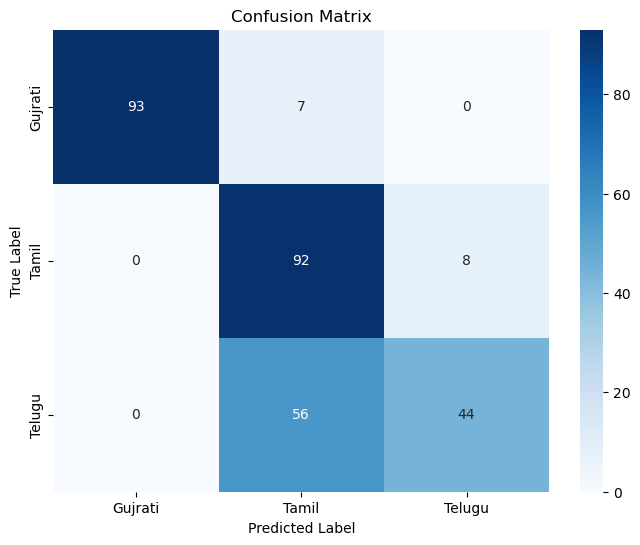

Overall Accuracy: 76.33%
Num comp:2, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1208400.4990367074, BIC: 1208413.7112755086
Converged at 45
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1290338.4774046321, BIC: 1290351.848912298
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 899338.0428169982, BIC: 899350.7760226638
Silhouette Score: -0.101647094


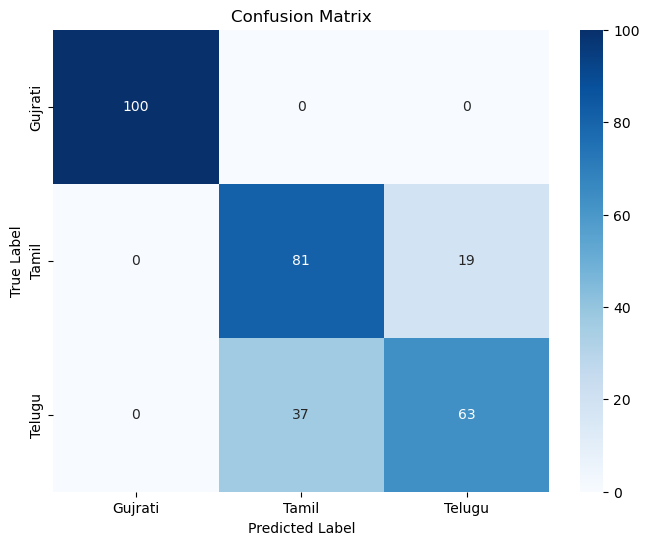

Overall Accuracy: 81.33%
Num comp:4, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1175139.3371026497, BIC: 1175165.761580252
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1247830.5285230763, BIC: 1247857.2715384082
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 873652.4839309794, BIC: 873677.9503423105
Silhouette Score: -0.13789243


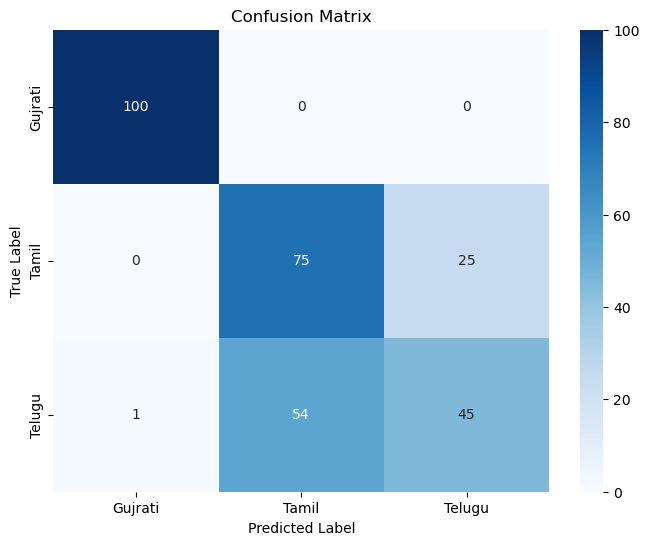

Overall Accuracy: 73.33%
Num comp:8, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1147079.1506964196, BIC: 1147131.9996516246
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1218939.846149831, BIC: 1218993.3321804947
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 854489.8323340806, BIC: 854540.7651567429
Silhouette Score: -0.18817501


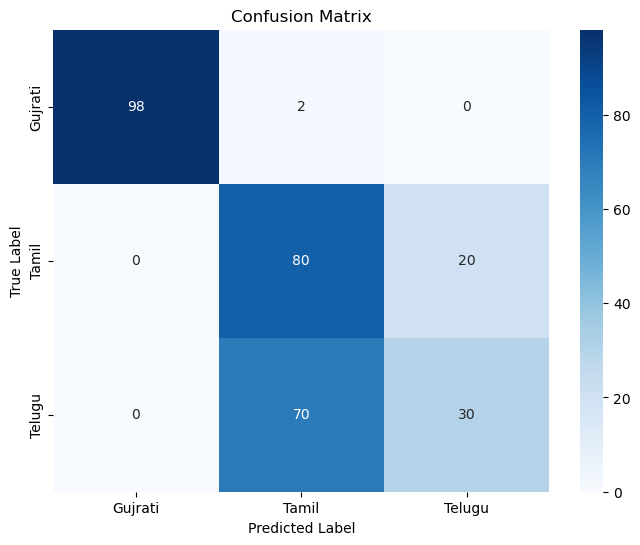

Overall Accuracy: 69.33%
Num comp:16, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1118399.1388083277, BIC: 1118504.8367187376
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1185813.5557790245, BIC: 1185920.527840352
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 834249.1926061047, BIC: 834351.0582514292
Silhouette Score: -0.18714823


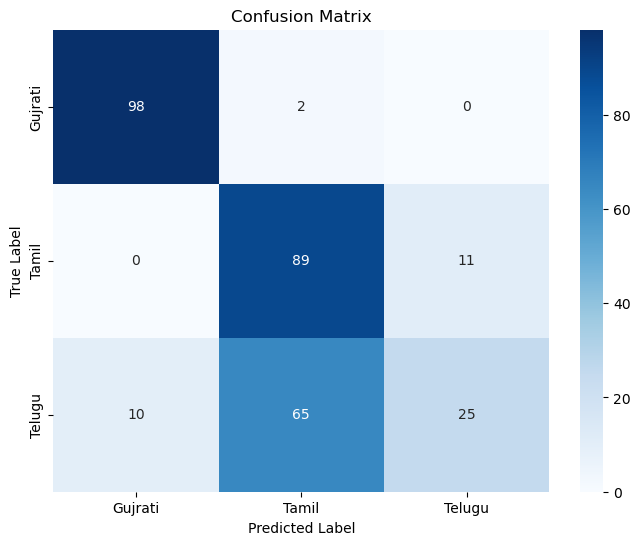

Overall Accuracy: 70.67%
Num comp:32, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1087213.086650357, BIC: 1087424.4824711767
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1150850.0900802799, BIC: 1151064.0342029345
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 808434.0856405322, BIC: 808637.8169311812
Silhouette Score: -0.3125426


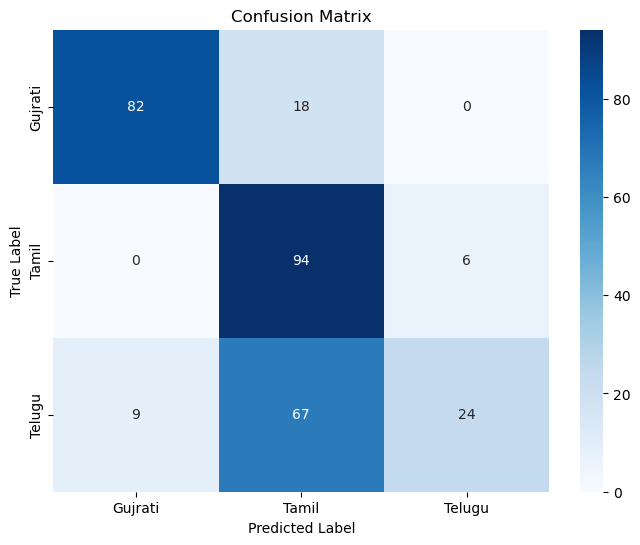

Overall Accuracy: 66.67%
Num comp:64, Num PCA:39
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 1024160.1748467624, BIC: 1024582.9664884015
Converged at 30
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 1092997.1203356935, BIC: 1093425.008581003
Converged at 4
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 713049.1172508104, BIC: 713456.5798321086
Silhouette Score: -0.1776124


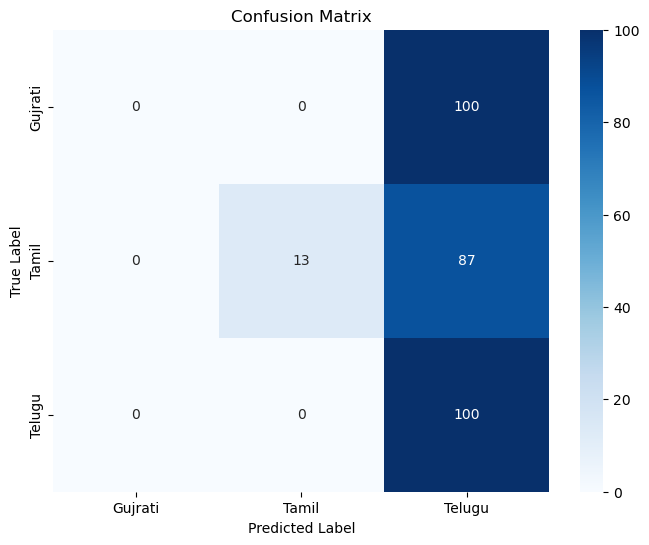

Overall Accuracy: 37.67%


In [21]:
import warnings
warnings.filterwarnings("ignore")

n_comp_list = [1,2,4,8,16,32,64]
num_pca_list = [1,2,8,16,24,39]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand)

# Testing

In [22]:
def pipeline_full(n_components_gmm,is_pca,num_pca):
    gmms = []

    for path in train_paths:
        X = preprocess_folder(path,is_pca,num_pca,items=1)
        gmm = GMMNew(n_components_gmm,100,'full')
        gmm.fit(data=X)
        gmms.append(gmm)
        with open(f'gmmfull_{n_components_gmm}_{num_pca}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        print(f"{path} is done")

    # Initialize confusion matrix
    confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

    for idx, path in enumerate(test_paths):
        # Initialize counters for each class
        class_counts = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file,is_pca,num_pca)
                log_likelihood = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm    = gmms[i]  #checking with each model one by one
                    log_likelihood[i] = gmm.get_score(vector)
            
                winner = np.argmax(log_likelihood)
                class_counts[winner] += 1  # Increment the count for the winner class

        # Update confusion matrix
        for true_label, count in class_counts.items():
            confusion_matrix[idx, true_label] = count

    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")

Num comp:32, Num PCA:24


../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 906780.184593562, BIC: 906991.5804143816
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 974249.1816685419, BIC: 974463.1257911966
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 677333.2656857914, BIC: 677536.9969764404
Silhouette Score: -0.0186502


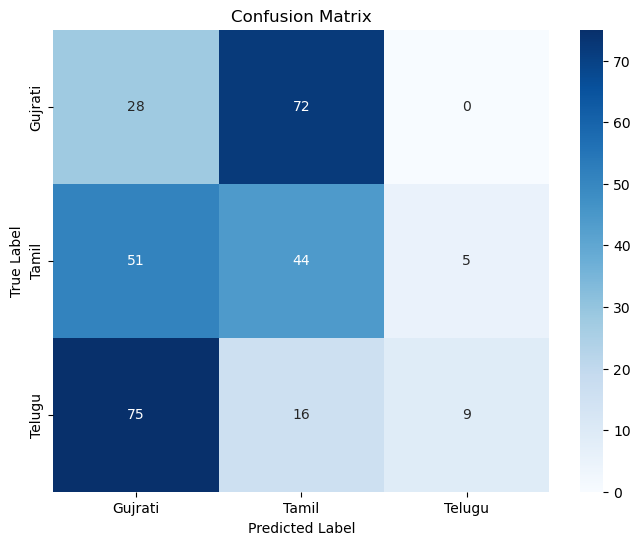

Overall Accuracy: 27.00%
Num comp:64, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 882962.5792709137, BIC: 883385.3709125528
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 944549.6154402378, BIC: 944977.5036855473
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 657768.2591226044, BIC: 658175.7217039026
Silhouette Score: -0.06826001


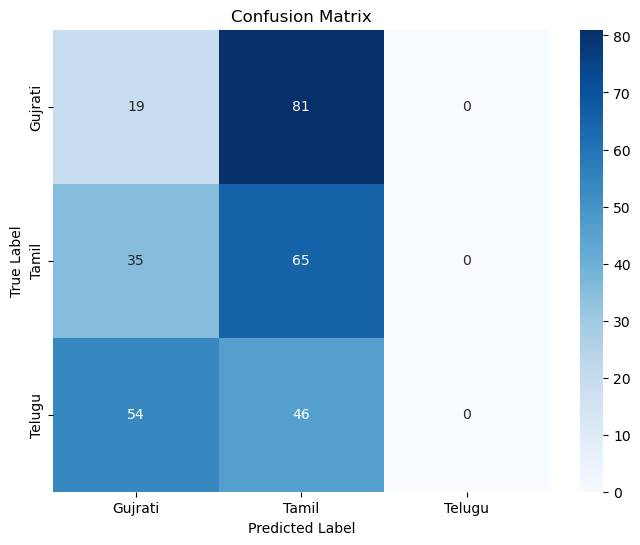

Overall Accuracy: 28.00%
Num comp:128, Num PCA:24
Converged at 42
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 816898.3646590298, BIC: 817743.9479423079
Converged at 44
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
Model 2 AIC: 880347.5211486693, BIC: 881203.2976392882
Converged at 81
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done
Model 3 AIC: 575658.6222886143, BIC: 576473.5474512106
Silhouette Score: -0.19996162


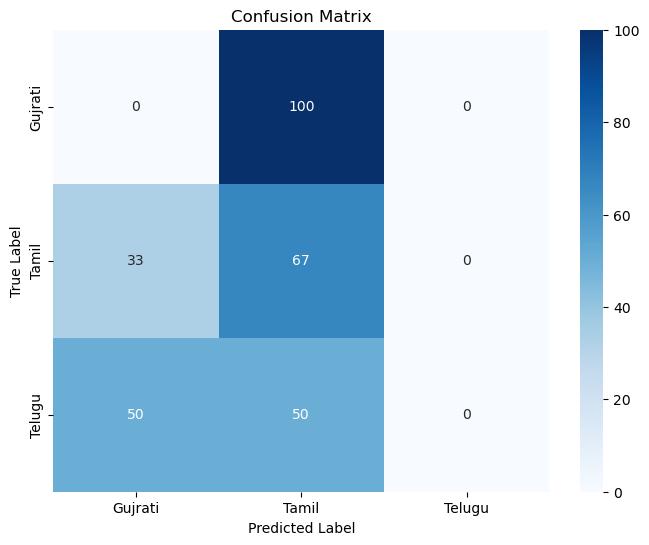

Overall Accuracy: 22.33%
Num comp:256, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
Model 1 AIC: 462740.3072273242, BIC: 464431.47379388055


ValueError: array must not contain infs or NaNs

In [23]:
n_comp_list = [32, 64, 128, 256, 512]
num_pca_list = [24, 39]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand)